In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import torch
import numpy


/home/owkin/deepdeconv/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/deepdeconv/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# load toy dataset
adata = scvi.data.heart_cell_atlas_subsampled()
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [7]:
adata.obs["cell_type"].unique()

['Myeloid', 'Ventricular_Cardiomyocyte', 'Fibroblast', 'Endothelial', 'Adipocytes', ..., 'Atrial_Cardiomyocyte', 'Smooth_muscle_cells', 'Neuronal', 'Lymphoid', 'Mesothelial']
Length: 11
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

In [8]:
# Create and train model
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_type"], #"cell_source", "donor"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [9]:
model = scvi.model.SCVI(adata)
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['cell_type'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 18641 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 1200  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │        Adipocytes         │          0          │
│                        │   Atrial_Cardiomyocyte    │          1          │
│                        │        Endothelial        │          2          │
│                        │        Fibroblast         │          3          │
│                        │         Lymphoid          │          4          │
│                        │        Mesothelial        │          5          │
│                        │          Myeloid          │          6          │
│                        │         Neuronal          │          7          │
│                        │         Pericytes         │          8          │
│                        │    Smooth_muscle_cells    │          9          │
│                        │ Ventricular_Cardiomyocyte │         10          │
│                        │                           │                     │
└────────────────────────┴───────────────────────────┴─────────────────────┘

In [10]:
model.train(max_epochs=100,
            batch_size=512)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:54<00:00,  1.87it/s, v_num=1, train_loss_step=281, train_loss_epoch=284]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s, v_num=1, train_loss_step=281, train_loss_epoch=284]


In [14]:
import matplotlib.pyplot as plt

In [15]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'l2_loss_train', 'pearson_coeff_train', 'cosine_similarity_train', 'pearson_coeff_deconv_train'])

Text(0.5, 1.0, 'ELBO & train resonctruction loss')

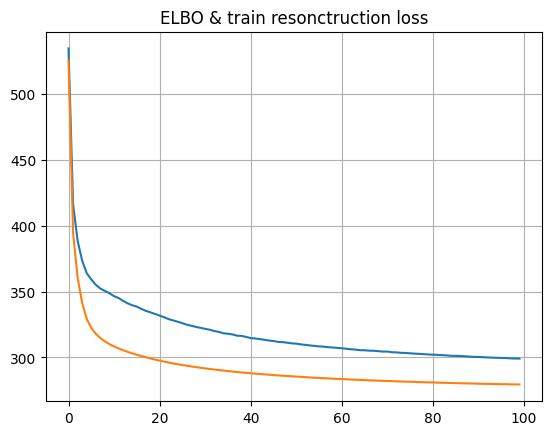

In [16]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["reconstruction_loss_train"])
plt.grid(True)
plt.title("ELBO & train resonctruction loss")

Text(0.5, 1.0, 'L2 loss')

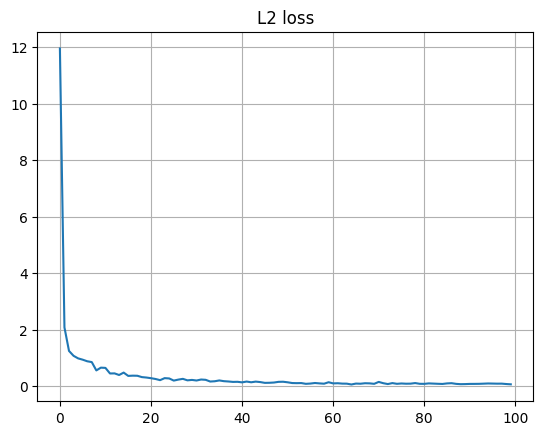

In [17]:
plt.plot(model.history["l2_loss_train"])
plt.grid(True)
plt.title("L2 loss")

Text(0.5, 1.0, 'Pearson correlation')

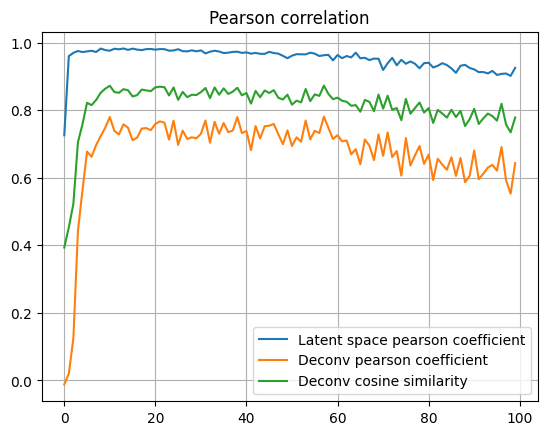

In [18]:
plt.plot(model.history["pearson_coeff_train"], label="Latent space pearson coefficient")
plt.plot(model.history["pearson_coeff_deconv_train"], label="Deconv pearson coefficient")
plt.plot(model.history["cosine_similarity_train"], label="Deconv cosine similarity")
plt.legend()
plt.grid(True)
plt.title("Pearson correlation")

Text(0.5, 1.0, 'KL divergence')

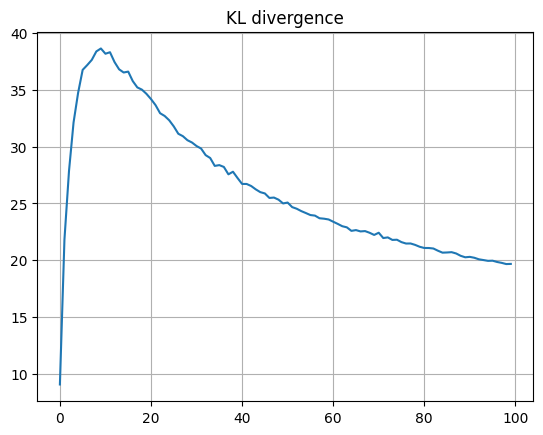

In [19]:
plt.plot(model.history["kl_local_train"])
plt.grid(True)
plt.title("KL divergence")